## Discussion 5 - Comparing MintPy with GIAnT ##
+ Figure 16 - Comparing MintPy with GIAnT (SBAS, NSBAS and TimeFun alogrithms).
+ Figure S9 - Impact of weighting and unwrapping-error correction on the displacement time-series 

In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt, ticker
from matplotlib.gridspec import GridSpec
from mintpy.defaults.plot import *
from mintpy.objects import timeseries, ifgramStack, sensor
from mintpy.utils import readfile, ptime, plot as pp, utils as ut
from mintpy import view

work_dir = os.path.expanduser('~/Documents/Paper/2019_MintPy/Notebooks/mintpy_vs_giant')
os.chdir(work_dir)
print('Go to directory: '+work_dir)

proj_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/giant')
proj_name = sensor.project_name2sensor_name(proj_dir)[1]

ts_files = [os.path.join(proj_dir, i) for i in ['mintpy/timeseries_ECMWF_ramp_demErr.h5',
                                                'Stack/NSBAS-PARAMS.h5',  #same as SBAS for its pts
                                                'Stack/TS-PARAMS.h5']]
vel_files = [os.path.join(proj_dir, i) for i in ['mintpy/velocity.h5',
                                                 'LS-velocity.h5',
                                                 'NSBAS-velocity.h5',
                                                 'TS-velocity.h5']]
tcoh_file = os.path.join(proj_dir, 'mintpy/temporalCoherence.h5')
geom_file = os.path.join(proj_dir, '../mintpy/inputs/geometryRadar.h5')

# Info
atr = readfile.read_attribute(ts_files[0])
coord = ut.coordinate(atr, geom_file)
date_list = timeseries(ts_files[0]).get_date_list()
dates, datevector = ptime.date_list2vector(date_list)

## Points of Interest
pt_A = [-0.4369, -91.1162]  #A, Alcedo crater center, high coherent w/o unw err  --> all the same
pt_B = [-0.3750, -91.0781]  #B, Alcedo lava flow, low coherent w/o unw err       --> g-nsbas underestimated
pt_C = [-0.3637, -91.5287]  #C, Fernandina caldera, low coherent w unw err       --> g-sbas/nsbas overestimated due to unw err, g-timefun filering
pt_D = [-0.3706, -91.5418]  #D, Fernandina caldera, low temp coh                 --> g-nsbas/mintpy give result, but mintpy dropped due to low tcoh
pts_lalo = [pt_C, pt_B, pt_A]

#convert lalo to yx
pts_yx = []
for lat, lon in pts_lalo:
    y, x = coord.geo2radar(lat, lon)[0:2]
    pts_yx.append([y, x])
num_pts = len(pts_yx)

Go to directory: /Users/yunjunz/Documents/Paper/2019_MintPy/Notebooks/mintpy_vs_giant


In [2]:
## prepare histogram data for (a-d)
# Read mintpy
num_mintpy      = readfile.read(os.path.join(proj_dir, 'mintpy/numInvIfgram.h5'))[0].flatten()
mask_mintpy_out = readfile.read(os.path.join(proj_dir, 'mintpy/maskTempCoh.h5'))[0].flatten()
mask_mintpy_in  = num_mintpy != 0.
num_mintpy_max = np.max(num_mintpy[mask_mintpy_in])
# Read GIANT
num_giant = readfile.read(os.path.join(proj_dir, 'Stack/NSBAS-PARAMS.h5'), datasetName='ifgcnt')[0].flatten()
num_giant_max = np.max(num_giant)
mask_gsbas = num_giant == num_giant_max
mask_gnsbas = num_giant != 0.
mask_gnsbas *= ~np.isnan(num_giant)
mask_gtimefun = np.array(mask_gsbas)
# summarize data
num_data = (num_mintpy[mask_mintpy_in],
            num_mintpy[mask_mintpy_out],
            num_giant[mask_gsbas],
            num_giant[mask_gnsbas],
            num_giant[mask_gtimefun])
print('Done.')

Done.


save figure to vel_GalapagosSenDT128.png


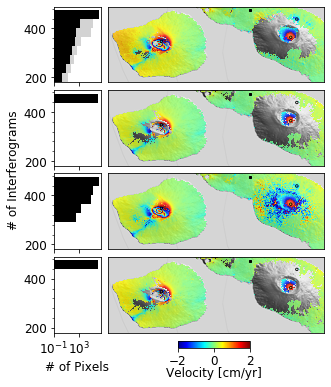

In [3]:
# (a-h) - Histogram and Linear Velocity Map

fig = plt.figure(figsize=(5, 6))
gs = GridSpec(4, 6, figure=fig)
axs1 = [fig.add_subplot(gs[0, 0]),
        fig.add_subplot(gs[1, 0]),
        fig.add_subplot(gs[2, 0]),
        fig.add_subplot(gs[3, 0])]
axs2 = [fig.add_subplot(gs[0, 1:]),
        fig.add_subplot(gs[1, 1:]),
        fig.add_subplot(gs[2, 1:]),
        fig.add_subplot(gs[3, 1:])]

# Fig. (a-d) histogram
for i in range(1,len(axs1)):
    axs1[i].get_shared_x_axes().join(axs1[i], axs1[0])
    axs1[i].get_shared_y_axes().join(axs1[i], axs1[0])
min_num_ifg = 180

for i in [0,1,2,3,4]:
    if i == 0:
        ax = axs1[0]
        color = 'lightgray'
    else:
        ax = axs1[i-1]
        color = 'black'
    ax.hist(num_data[i], bins=8, histtype='stepfilled', range=(min_num_ifg, num_mintpy_max), log=True, color=color, orientation='horizontal')
# axis format
for ax in axs1:
    ax.tick_params(which='both', direction='out', labelsize=font_size)
    ax.set_ylim(bottom=min_num_ifg)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    if ax != axs1[-1]:
        ax.get_xaxis().set_ticklabels([])
axs1[-1].set_xlabel('# of Pixels', fontsize=font_size)
pp.set_shared_ylabel(axs1, '# of Interferograms', font_size=font_size)

# Fig. (e-h) - velocity
for i in range(len(vel_files)):
    ax = axs2[i]
    cmd  = 'view.py {} velocity -d {} --dem-nocontour '.format(vel_files[i], geom_file)
    cmd += '--sub-x 400 1680 --sub-y 750 1200 '
    cmd += '-u cm --wrap --wrap-range -2 2 -c jet '
    cmd += '--notitle --notick --ref-size 2 --nocbar --fontsize 12 '
    cmd += ' --noverbose '
    d_v, atr, inps = view.prep_slice(cmd)
    ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps)
fig.subplots_adjust(hspace=0.1, wspace=-0.02)
# point of interest
for i in range(len(pts_yx)):
    y, x = pts_yx[i]
    for ax in axs2:
        ax.scatter(x, y, s=2.5**2, color='none', edgecolors='k', lw=0.8, zorder=10)
# colorbar
cax = fig.add_axes([0.47, 0.09, 0.2, 0.015])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', ticks=[-2, 0, 2])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Velocity [cm/yr]', fontsize=font_size, labelpad=-1)

# save
out_file= 'vel_{}.png'.format(proj_name)
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to {}'.format(out_file))
plt.show()

In [4]:
## Run to get Points of Interest @ GIANT/Stack directory
#!tsview.py ../mintpy/timeseries_ECMWF_demErr_ramp.h5 TS-PARAMS.h5 NSBAS-PARAMS.h5 TS-PARAMS.h5 --ylim -20 40 --label mintpy g-sbas g-nsbas g-timefun --wrap --wrap-range -5 5 --zf -l ../../mintpy/inputs/geometryRadar.h5 --yx 825 562

saved to file /Users/yunjunz/Documents/Paper/2019_MintPy/Notebooks/mintpy_vs_giant/ts_GalapagosSenDT128.png


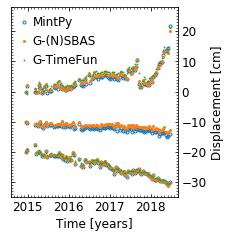

In [5]:
## (i) - Displacement time-series on pixels of interest

# setting
offs = [0, -10, -20]
unit_scales = [100., 0.1, 0.1]
ms_list = np.array([3, 2, 0.8])
colors = pp.mplColors[0:3]
labels = ['MintPy', 'G-(N)SBAS', 'G-TimeFun']

def plot_one_pixel(ax, box, off=0.):
    for i in range(len(ts_files)):
        dis_ts = readfile.read(ts_files[i], box=box, print_msg=False)[0] * unit_scales[i]
        dis_ts -= dis_ts[0]
        # temp coh and masking
        pts_tcoh = readfile.read(tcoh_file, box=box, print_msg=False)[0]
        if i == 0:
            pts_mec = colors[i]
            pts_mfc = 'none'
            pts_label = labels[i]
            if pts_tcoh < 0.7:
                pts_mec = 'gray'
                print('dropped: {}'.format(pts_tcoh))
        else:
            pts_mec = colors[i]
            pts_mfc = colors[i]
            pts_label = labels[i]
        ax.plot(dates, dis_ts+off, 'o', label=pts_label, ms=ms_list[i], mec=pts_mec, mfc=pts_mfc)
    return ax

## plot
fig, ax = plt.subplots(figsize=(3, 3.5))
for i in range(len(pts_yx)):
    y, x = pts_yx[i]
    ax = plot_one_pixel(ax, box=(x, y, x+1, y+1), off=offs[i])
# axis format
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(10))
pp.auto_adjust_xaxis_date(ax, datevector, fontsize=font_size)
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.set_ylim(-35, 28)
ax.set_xlabel('Time [years]', fontsize=font_size)
ax.set_ylabel('Displacement [cm]', fontsize=font_size)
# legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[3:6], labels[3:6], loc=(-0.02, 0.66), fontsize=font_size, frameon=False, borderaxespad=0.15, handletextpad=-0.3)

# save
out_file = os.path.join(os.getcwd(), 'ts_{}.png'.format(proj_name))
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('saved to file {}'.format(out_file))
plt.show()

start/end date: 20170507/20180619
save figure to file /Users/yunjunz/Documents/Paper/2019_MintPy/Notebooks/mintpy_vs_giant/mintpy_vs_giant_coh_mat.png


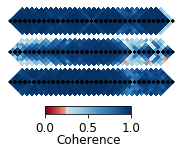

In [6]:
## (j) - coherence matrix of POIs

ifg_file = os.path.join(proj_dir, '../mintpy/inputs/ifgramStack.h5')
stack_obj = ifgramStack(ifg_file)
stack_obj.open(print_msg=False)

# get date12_list between (min_date, max_date)
min_date, max_date = '20170501', '20180619'
date12_list0 = stack_obj.get_date12_list(dropIfgram=False)
tempList  = [i for i in date12_list0 if any(int(j) < int(min_date) for j in i.split('_'))]
tempList += [i for i in date12_list0 if any(int(j) > int(max_date) for j in i.split('_'))]
date12_list = sorted(list(set(date12_list0) - set(tempList)))
dset_list = ['coherence-{}'.format(i) for i in date12_list]
# info
mDates = [i.split('_')[0] for i in date12_list]
sDates = [i.split('_')[1] for i in date12_list]
dateList = sorted(list(set(mDates + sDates)))
print('start/end date: {}/{}'.format(dateList[0], dateList[-1]))

## plot
fig, axs = plt.subplots(nrows=num_pts, ncols=1, figsize=[3, 3])
cmap = pp.ColormapExt('RdBu_truncate', vlist=[0, 0.25, 1]).colormap
for i in range(num_pts):
    y, x = pts_yx[i]
    box = (x, y, x+1, y+1)
    coh = np.squeeze(readfile.read(ifg_file, datasetName=dset_list, box=box, print_msg=False)[0])
    # get date12_list_drop
    coh_date12_list = list(np.array(date12_list)[coh >= 0.25])
    date12_list_drop = [i for i in date12_list if i not in coh_date12_list]
    #plot
    ax = axs[i]
    ax, im = pp.plot_rotate_diag_coherence_matrix(ax, coh.tolist(), date12_list, date12_list_drop, cmap=cmap, disp_min=0.0)
fig.subplots_adjust(hspace=-0.7)
# plot colorbar
cax = fig.add_axes([0.3, 0.215, 0.4, 0.035])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=font_size)
cbar.locator = ticker.MaxNLocator(nbins=2)
cbar.update_ticks()
cbar.set_label('Coherence', fontsize=font_size, labelpad=-1)

# output
out_file = os.path.join(work_dir, 'mintpy_vs_giant_coh_mat.png')
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

saved to file /Users/yunjunz/Documents/Paper/2019_MintPy/Notebooks/mintpy_vs_giant/pixel_B_compare.png


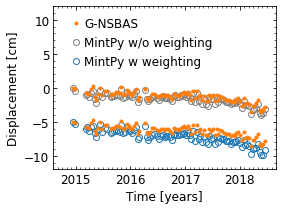

In [7]:
## Fig. S9a - Weighting (point B)
## to prove: the difference in displacement time-series is due to weighting in the network inversion.

# read time-series data
ts_files = [os.path.join(proj_dir, i) for i in ['Stack/NSBAS-PARAMS.h5',  #same as SBAS for its pts
                                                'mintpy/NO_WEIGHT/timeseries_ECMWF_ramp_demErr.h5',
                                                'mintpy/timeseries_ECMWF_ramp_demErr.h5',]]
unit_scales = [0.1, 100., 100.]
y, x = coord.geo2radar(pt_B[0], pt_B[1])[0:2]
box = (x, y, x+1, y+1)
tss = []
for i in range(len(ts_files)):
    dis = readfile.read(ts_files[i], box=box)[0] * unit_scales[i]
    dis -= dis[0]
    tss.append(dis)

# plot
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(dates, tss[1] - 0, 'o', label='MintPy w/o weighting',    ms=6, mec='gray', mfc='none')
ax.plot(dates, tss[0] - 0, 'o', label='G-NSBAS',  ms=3, mec=pp.mplColors[1], mfc=pp.mplColors[1])
ax.plot(dates, tss[2] - 5, 'o', label='MintPy w weighting',    ms=6, mec=pp.mplColors[0], mfc='none')
ax.plot(dates, tss[0] - 5, 'o', label='G-NSBAS',  ms=3, mec=pp.mplColors[1], mfc=pp.mplColors[1])
# axis format
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
pp.auto_adjust_xaxis_date(ax, datevector, fontsize=font_size)
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.set_ylim(-12, 12)
ax.set_xlabel('Time [years]', fontsize=font_size)
ax.set_ylabel('Displacement [cm]', fontsize=font_size)
# legend
handles, labels = ax.get_legend_handles_labels()
plt.legend([handles[1], handles[0], handles[2]], [labels[1], labels[0], labels[2]], 
           loc='upper left', fontsize=font_size, frameon=False, handletextpad=-0.3)

# output
out_file = os.path.join(os.getcwd(), 'pixel_B_compare.png')
print('saved to file {}'.format(out_file))
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

saved to file /Users/yunjunz/Documents/Paper/2019_MintPy/Notebooks/mintpy_vs_giant/pixel_C_compare.png


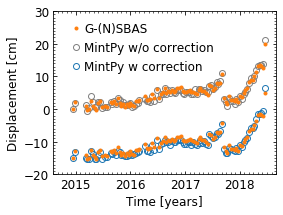

In [8]:
## Fig. S9b - Unwrapping error correction (point C)
## to prove: the difference in displacement time-series is due to unwrapping error correction 

# read time-series data
ts_files = [os.path.join(proj_dir, i) for i in ['Stack/NSBAS-PARAMS.h5',  #same as SBAS for its pts
                                                'MintPy/WO_UNW_COR/timeseries_ECMWF_ramp_demErr.h5',
                                                'MintPy/timeseries_ECMWF_ramp_demErr.h5',]]
unit_scales = [0.1, 100., 100.]
y, x = coord.geo2radar(pt_C[0], pt_C[1])[0:2]
box = (x, y, x+1, y+1)
tss = []
for i in range(len(ts_files)):
    dis = readfile.read(ts_files[i], box=box)[0] * unit_scales[i]
    dis -= dis[0]
    tss.append(dis)

# plot
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(dates, tss[1] - 0,  'o', label='MintPy w/o correction',    ms=6, mec='gray', mfc='none')
ax.plot(dates, tss[0] - 0,  'o', label='G-(N)SBAS',  ms=3, mec=pp.mplColors[1], mfc=pp.mplColors[1])
ax.plot(dates, tss[2] - 15, 'o', label='MintPy w correction',    ms=6, mec=pp.mplColors[0], mfc='none')
ax.plot(dates, tss[0] - 15, 'o', label='G-NSBAS',  ms=3, mec=pp.mplColors[1], mfc=pp.mplColors[1])
# axis format
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(10))
pp.auto_adjust_xaxis_date(ax, datevector, fontsize=font_size)
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.set_ylim(-20, 30)
ax.set_xlabel('Time [years]', fontsize=font_size)
ax.set_ylabel('Displacement [cm]', fontsize=font_size)
# legend
handles, labels = ax.get_legend_handles_labels()
plt.legend([handles[1], handles[0], handles[2]], [labels[1], labels[0], labels[2]], 
           loc='upper left', fontsize=font_size, frameon=False, handletextpad=-0.3)

# output
out_file = os.path.join(os.getcwd(), 'pixel_C_compare.png')
print('saved to file {}'.format(out_file))
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

start/end date: 20141213/20180619


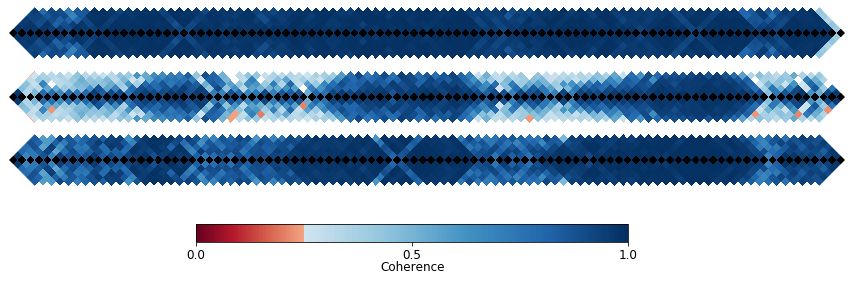

In [9]:
## Backup - coherence matrix of POIs - FULL TIME PERIOD
cmap = pp.ColormapExt('RdBu_truncate', vlist=[0, 0.25, 1]).colormap
min_date, max_date = '20141201', '20180619'

ifg_file = os.path.join(proj_dir, '../mintpy/inputs/ifgramStack.h5')
stack_obj = ifgramStack(ifg_file)
stack_obj.open(print_msg=False)
# get date12_list between (min_date, max_date)
date12_list0 = stack_obj.get_date12_list(dropIfgram=False)
tempList  = [i for i in date12_list0 if any(int(j) < int(min_date) for j in i.split('_'))]
tempList += [i for i in date12_list0 if any(int(j) > int(max_date) for j in i.split('_'))]
date12_list = sorted(list(set(date12_list0) - set(tempList)))
dset_list = ['coherence-{}'.format(i) for i in date12_list]
# info
mDates = [i.split('_')[0] for i in date12_list]
sDates = [i.split('_')[1] for i in date12_list]
dateList = sorted(list(set(mDates + sDates)))
print('start/end date: {}/{}'.format(dateList[0], dateList[-1]))

# plot
fig, axs = plt.subplots(nrows=num_pts, ncols=1, figsize=[15, 7])
for i in range(num_pts):
    y, x = pts_yx[i]
    box = (x, y, x+1, y+1)
    coh = np.squeeze(readfile.read(ifg_file, datasetName=dset_list, box=box, print_msg=False)[0])
    # get date12_list_drop
    coh_date12_list = list(np.array(date12_list)[coh >= 0.25])
    date12_list_drop = [i for i in date12_list if i not in coh_date12_list]
    #plot
    ax = axs[i]
    ax, im = pp.plot_rotate_diag_coherence_matrix(ax, coh.tolist(), date12_list, date12_list_drop, cmap=cmap, disp_min=0.0)
fig.subplots_adjust(hspace=-0.75)
# plot colorbar
cax = fig.add_axes([0.3, 0.215, 0.4, 0.035])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=font_size)
cbar.locator = ticker.MaxNLocator(nbins=2)
cbar.update_ticks()
cbar.set_label('Coherence', fontsize=font_size, labelpad=-1)

#plt.savefig('mintpy_vs_giant_coh_mat.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()